In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

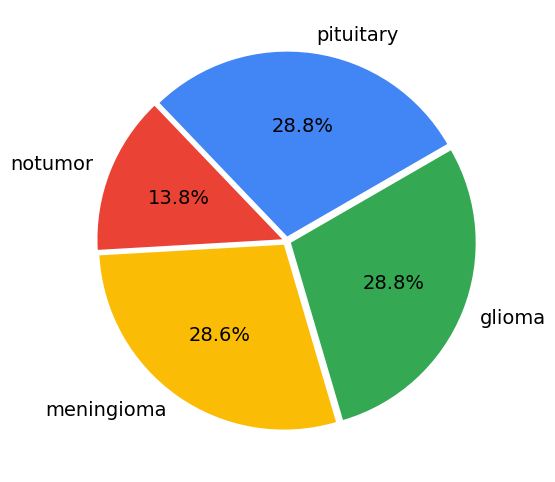

In [34]:
train_dataset = ['/kaggle/input/brain-tumor-classification-mri/Training/']
test_dataset = ['/kaggle/input/brain-tumor-classification-mri/Testing/']
train_paths = []
train_labels = []

for train_dir in train_dataset:
    for label in os.listdir(train_dir):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']: 
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(train_dir+label):
            train_paths.append(train_dir+label+'/'+image)
            train_labels.append(real_label)

train_paths, train_labels = shuffle(train_paths, train_labels)
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x == 'pituitary']),
         len([x for x in train_labels if x == 'notumor']),
         len([x for x in train_labels if x == 'meningioma']),
         len([x for x in train_labels if x == 'glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

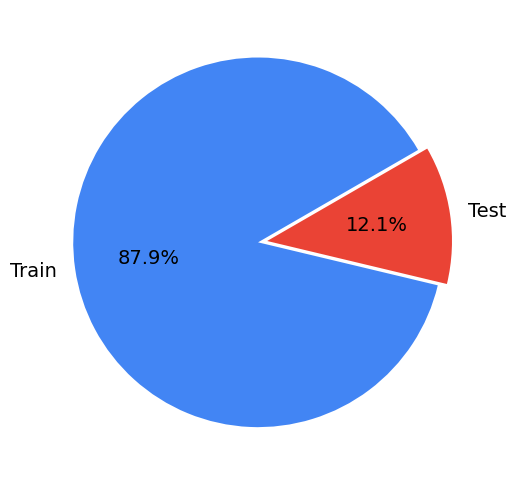

In [35]:
test_paths = []
test_labels = []

for test_dir in test_dataset:
    for label in os.listdir(test_dir):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']: 
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(test_dir+label):
            test_paths.append(test_dir+label+'/'+image)
            test_labels.append(real_label)

test_paths, test_labels = shuffle(test_paths, test_labels)

plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),startangle=30);

In [36]:
def show_confusion_matrix(model,x_test,y_test):
  from sklearn.metrics import confusion_matrix
  from sklearn.model_selection import train_test_split

  # Split the data into training and testing sets
  # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
  # print(x_test.shape,y_test.shape)
  #do prediction
  prediction = model.predict(x_test)

  #convert predicted values to
  #y_pred = [1 if x > threshold else 0 for x in prediction]
  y_pred = prediction
  y_pred = [np.argmax(element) for element in y_pred]
  cm = confusion_matrix(y_test, y_pred)
  # print(cm)
  sns.heatmap(cm, annot=True, cmap='Blues',fmt='d')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

def classification_report_print(X_test,y_test):
  x_test = X_test

  y_pred = model.predict(x_test)
  from sklearn.metrics import classification_report
  y_classes = [np.argmax(element) for element in y_pred]

  y_pred = model.predict(x_test)
  print('classification Report \n',classification_report(y_test,y_classes))


def calculate_confusion_matrix(model,x_test,y_test):
  from sklearn.metrics import confusion_matrix
  from sklearn.model_selection import train_test_split

  # Split the data into training and testing sets
  # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  #do prediction
  prediction = model.predict(x_test)

  #convert predicted values to
  # y_pred = [1 if x > threshold else 0 for x in prediction]
  # y_pred[:20]

  y_pred = prediction
  y_pred = [np.argmax(element) for element in y_pred]

  cm = confusion_matrix(y_pred,y_test)
  return cm


def calculate_f1_score(confusion_matrix):
    from sklearn.metrics import f1_score
    tp = confusion_matrix[0][0]
    fp = confusion_matrix[0][1]
    fn = confusion_matrix[1][0]
    tn = confusion_matrix[1][1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score_val = 2 * (precision * recall) / (precision + recall)
    # print(f1_score_val)
    return f1_score_val
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA # Principal Component Analysis module
from sklearn.cluster import KMeans # KMeans clustering
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
import cv2
def applyPCA(image):
  pca = PCA(50)

  blue,green,red = cv2.split(image)
  r,g,b = red/255,green/255,blue/255

  #Applying to red channel and then applying inverse transform to transformed array.
  reduced_red = pca.fit_transform(r)
  reconstructed_red = pca.inverse_transform(reduced_red)

  #Applying to Green channel and then applying inverse transform to transformed array.
  reduced_green = pca.fit_transform(g)
  reconstructed_green = pca.inverse_transform(reduced_green)

  #Applying to Blue channel and then applying inverse transform to transformed array.
  reduced_blue = pca.fit_transform(b)
  reconstructed_blue = pca.inverse_transform(reduced_blue)

  # img_compressed = (np.dstack((reconstructed_red, reconstructed_red, reconstructed_red))).astype(np.uint8)
  img_pca =(cv2.merge((reduced_red, reduced_green, reduced_blue)))
  img_reconstructed = (cv2.merge((reconstructed_red, reconstructed_green, reconstructed_blue)))

  combined =  [reduced_red,reduced_green,reduced_blue]
  #viewing the compressed image
  # plt.imshow(red)
  # plt.imshow(green)
  # plt.imshow(blue)
  # plt.imshow(reduced_red)
  # plt.imshow(reconstructed_red)
  # plt.imshow(reduced_green)
  # plt.imshow(reconstructed_green)
  # plt.imshow(reduced_blue)
  # plt.imshow(reconstructed_blue)
  # plt.imshow(img_pca)
  # plt.imshow(img_reconstructed)
  # plt.imshow(img_pca)
  # plt.imshow(img_pca)
  # plt.imshow(img_pca)
  return img_pca


In [37]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


In [38]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X = np.array(X_train)
y = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 121.40it/s]


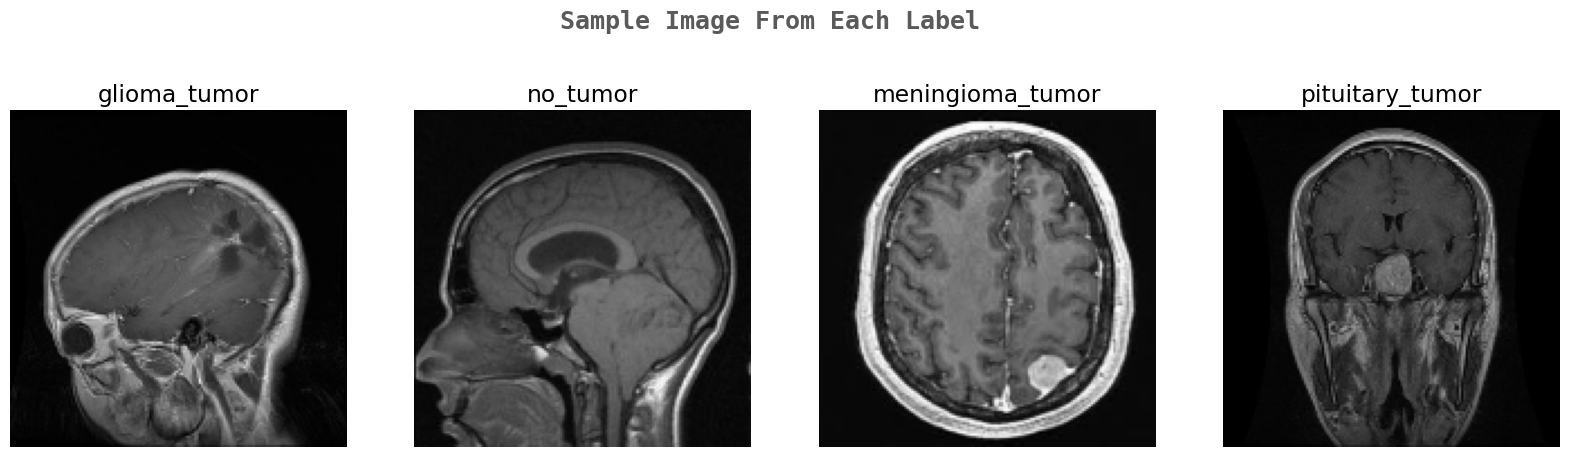

In [39]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']


# sns.palplot(colors_dark)
# sns.palplot(colors_green)
# sns.palplot(colors_red)
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [40]:
img = '/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(4).jpg'
cv2.imread(img).shape

(349, 425, 3)

In [41]:
img = '/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(3).jpg'
cv2.imread(img).shape

(256, 256, 3)

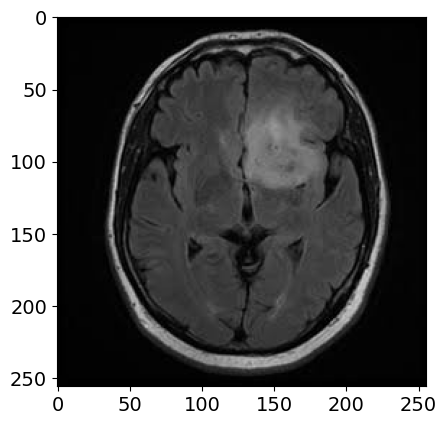

In [42]:
plt.imshow(cv2.imread(img))
plt.show()

In [43]:
X.shape,y.shape


((3264, 150, 150, 3), (3264,))

In [44]:
y[:10]


array(['glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor',
       'glioma_tumor', 'glioma_tumor', 'glioma_tumor', 'glioma_tumor',
       'glioma_tumor', 'glioma_tumor'], dtype='<U16')

In [45]:
X, y = shuffle(X,y, random_state=101)


In [46]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.1,random_state=101)


In [47]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = np.array(y_train_new)
y_train_cat = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = np.array(y_test_new)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [48]:
X_train.shape


(2937, 150, 150, 3)

In [49]:
y_train


array([0, 1, 1, ..., 2, 3, 2])

CNN Model

CNN model 1¶


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
model  = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(image_size,image_size,3)))
model.add(MaxPooling2D((2,2)),)

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(4, activation='softmax'))


#add cost function and backpropogation
#model.compile(loss=,optimizer=,metrics=)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [51]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
epochs =10
validation_split = 0.2
batch_size = 32

In [52]:
import datetime
start = datetime.datetime.now()
#Train the model
#model.fit(X_train,np.array(y_train),epochs=15)
history = model.fit(X_train,y_train,validation_split=validation_split, epochs=epochs , verbose=1, batch_size=batch_size)
end = datetime.datetime.now()
print("Total execution time is: ", end-start)


Epoch 1/10
74/74 [==============================] - 36s 478ms/step - loss: 5.6928 - accuracy: 0.5070 - val_loss: 0.8868 - val_accuracy: 0.6293
Epoch 2/10
74/74 [==============================] - 35s 479ms/step - loss: 0.7093 - accuracy: 0.7122 - val_loss: 0.6650 - val_accuracy: 0.7415
Epoch 3/10
74/74 [==============================] - 35s 473ms/step - loss: 0.4117 - accuracy: 0.8497 - val_loss: 0.5453 - val_accuracy: 0.8095
Epoch 4/10
74/74 [==============================] - 35s 479ms/step - loss: 0.2345 - accuracy: 0.9264 - val_loss: 0.6475 - val_accuracy: 0.7670
Epoch 5/10
74/74 [==============================] - 35s 477ms/step - loss: 0.1810 - accuracy: 0.9421 - val_loss: 0.4542 - val_accuracy: 0.8690
Epoch 6/10
74/74 [==============================] - 36s 488ms/step - loss: 0.0878 - accuracy: 0.9715 - val_loss: 0.5568 - val_accuracy: 0.8776
Epoch 7/10
74/74 [==============================] - 35s 477ms/step - loss: 0.0439 - accuracy: 0.9894 - val_loss: 0.5545 - val_accuracy: 0.8844

In [53]:
model.evaluate(X_test,y_test)


11/11 [==============================] - 1s 121ms/step - loss: 0.7479 - accuracy: 0.8624


[0.7479291558265686, 0.8623853325843811]

11/11 [==============================] - 1s 121ms/step
f1 score is: 0.9570552147239264
11/11 [==============================] - 1s 122ms/step


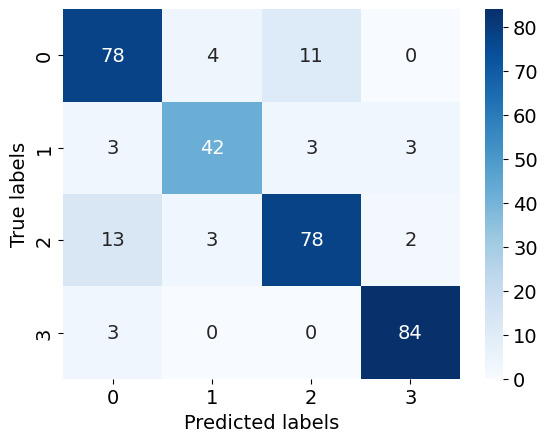

In [54]:
cm = calculate_confusion_matrix(model,X_test,y_test)
print(f'f1 score is: {calculate_f1_score(cm)}')
show_confusion_matrix(model,X_test,y_test)

In [55]:
classification_report_print(X_test,y_test)


11/11 [==============================] - 1s 119ms/step
classification Report 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        93
           1       0.86      0.82      0.84        51
           2       0.85      0.81      0.83        96
           3       0.94      0.97      0.95        87

    accuracy                           0.86       327
   macro avg       0.86      0.86      0.86       327
weighted avg       0.86      0.86      0.86       327



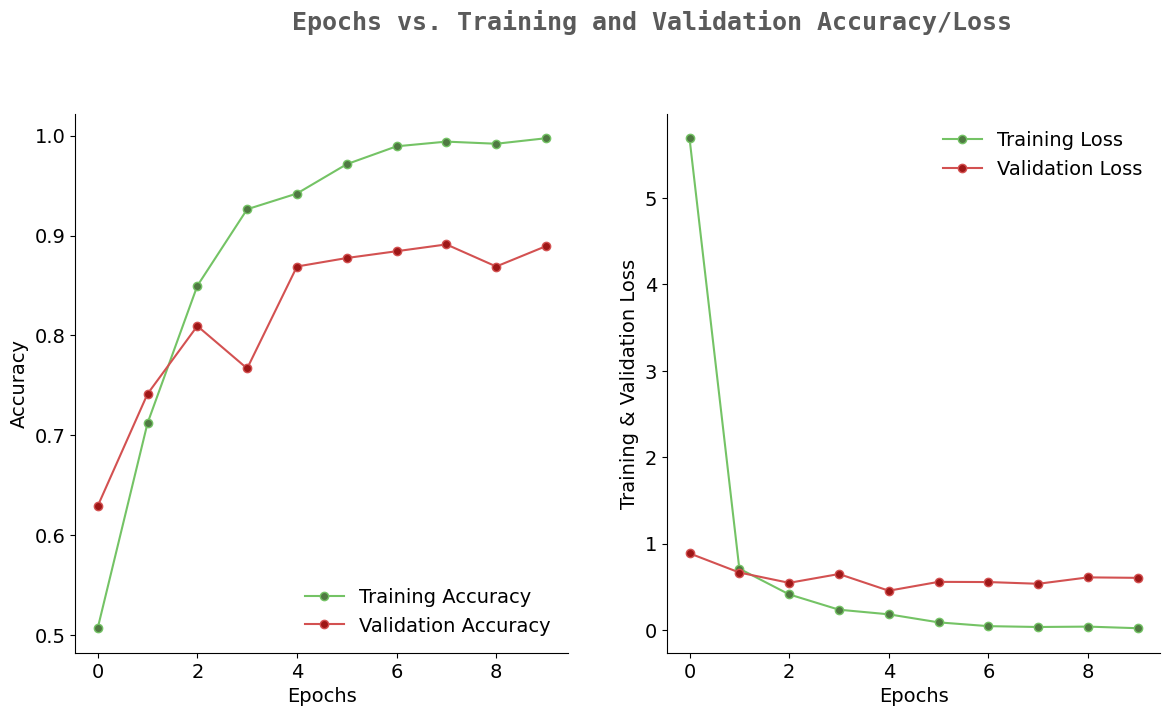

In [56]:
filterwarnings('ignore')
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

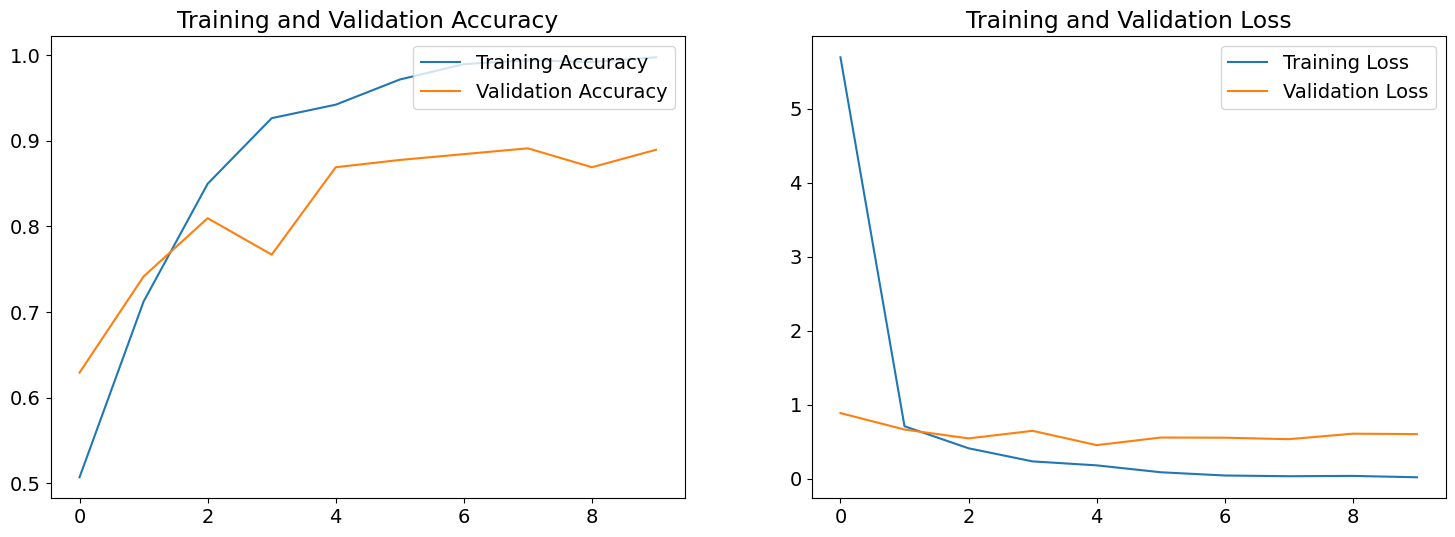

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

CNN model 2, With batch Normalization¶


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
model  = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(image_size,image_size,3)))
model.add(MaxPooling2D((2,2)),)

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(4, activation='softmax'))


#add cost function and backpropogation
#model.compile(loss=,optimizer=,metrics=)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [59]:
epochs =10
validation_split = 0.2
batch_size = 32

In [60]:
import datetime
start = datetime.datetime.now()
#Train the model
#model.fit(X_train,np.array(y_train),epochs=15)
history = model.fit(X_train,y_train,validation_split=validation_split, epochs=epochs , verbose=1, batch_size=batch_size)
end = datetime.datetime.now()
print("Total execution time is: ", end-start)
#model.save('/model.h5')
#model.save('CNNmodel2_batch.h5')#

Epoch 1/10
74/74 [==============================] - 37s 485ms/step - loss: 5.8985 - accuracy: 0.5304 - val_loss: 0.8321 - val_accuracy: 0.6769
Epoch 2/10
74/74 [==============================] - 36s 484ms/step - loss: 0.6198 - accuracy: 0.7586 - val_loss: 0.6272 - val_accuracy: 0.7636
Epoch 3/10
74/74 [==============================] - 35s 478ms/step - loss: 0.3776 - accuracy: 0.8587 - val_loss: 0.5732 - val_accuracy: 0.8146
Epoch 4/10
74/74 [==============================] - 35s 478ms/step - loss: 0.2029 - accuracy: 0.9293 - val_loss: 0.5186 - val_accuracy: 0.8452
Epoch 5/10
74/74 [==============================] - 35s 478ms/step - loss: 0.1702 - accuracy: 0.9451 - val_loss: 0.6643 - val_accuracy: 0.8435
Epoch 6/10
74/74 [==============================] - 35s 472ms/step - loss: 0.1002 - accuracy: 0.9642 - val_loss: 0.5747 - val_accuracy: 0.8724
Epoch 7/10
74/74 [==============================] - 35s 476ms/step - loss: 0.0655 - accuracy: 0.9804 - val_loss: 0.6418 - val_accuracy: 0.8554

In [61]:
model.evaluate(X_test,y_test)

11/11 [==============================] - 1s 118ms/step - loss: 0.9662 - accuracy: 0.8807


[0.9662113189697266, 0.8807339668273926]

11/11 [==============================] - 1s 117ms/step
f1 score is: 0.9876543209876543
11/11 [==============================] - 1s 123ms/step


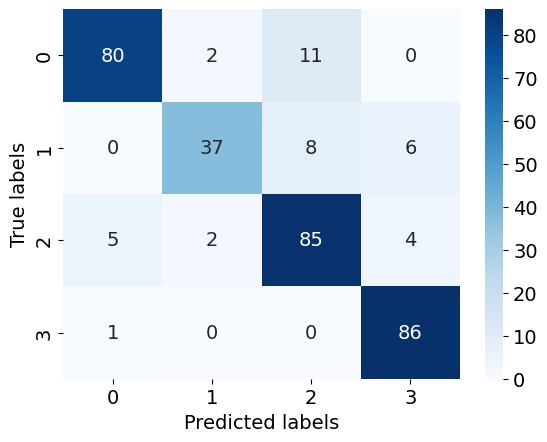

In [62]:
cm = calculate_confusion_matrix(model,X_test,y_test)
print(f'f1 score is: {calculate_f1_score(cm)}')
show_confusion_matrix(model,X_test,y_test)

In [63]:
classification_report_print(X_test,y_test)


11/11 [==============================] - 1s 116ms/step
classification Report 
               precision    recall  f1-score   support

           0       0.93      0.86      0.89        93
           1       0.90      0.73      0.80        51
           2       0.82      0.89      0.85        96
           3       0.90      0.99      0.94        87

    accuracy                           0.88       327
   macro avg       0.89      0.86      0.87       327
weighted avg       0.88      0.88      0.88       327



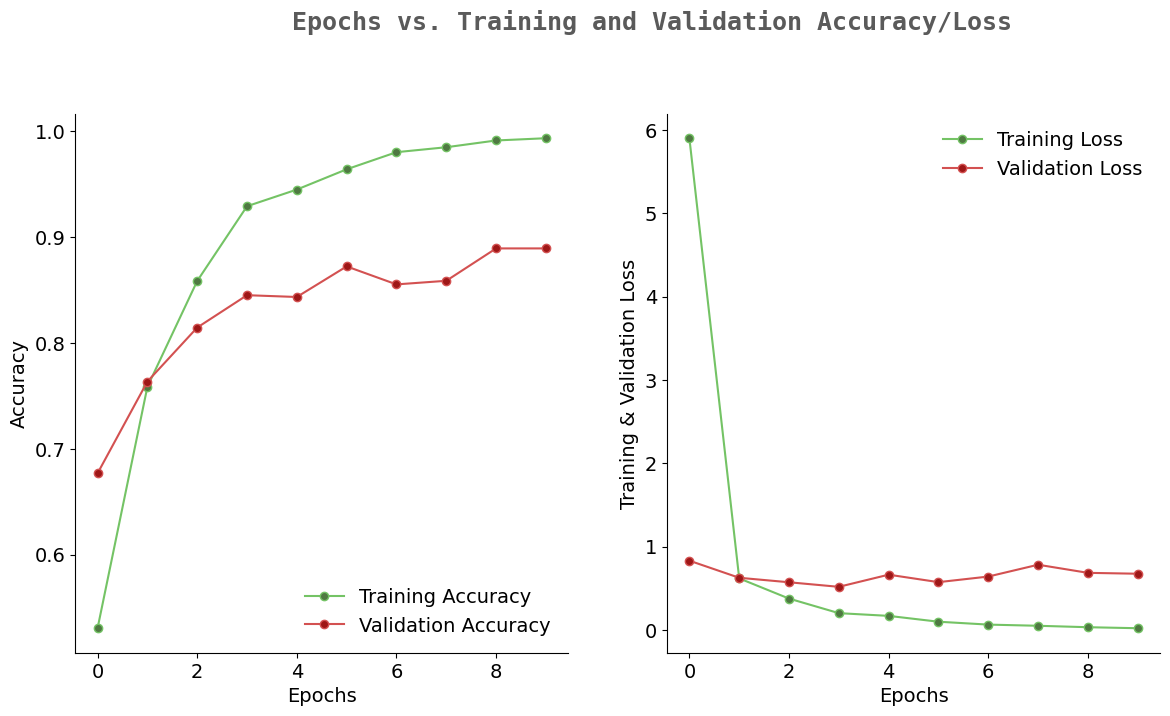

In [64]:
filterwarnings('ignore')
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

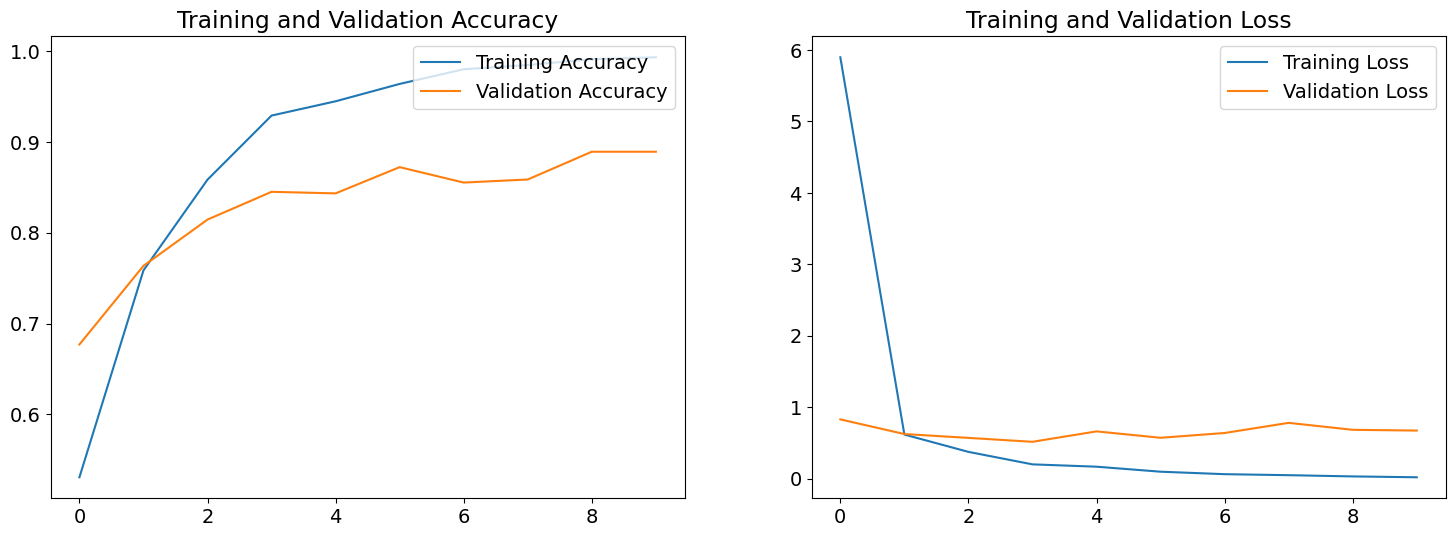

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Applying PCA to reduce dimensions of images


model that takes PCA of the images as input¶


In [66]:
X_PCA = []
y_PCA = []
for i in range(len(X_train)):
  image =  X_train[i,:]
  try:
    ans = applyPCA(np.array(image))
    ans = np.array(ans)
    # print(i)
    X_PCA.append(ans)
    y_PCA.append(y_train[i])
  except Exception as e:
    print(e)
    continue
    
# X = X/255

#divide data in split
import numpy as np
x_data = np.array(X_PCA)
y_data = y_PCA
from sklearn.model_selection import train_test_split
X_train_pca,x_test_pca,y_train_pca,y_test_pca = train_test_split(x_data,np.array(y_data),test_size = 0.2)
#x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
model  = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(image_size,50,3)))
model.add(MaxPooling2D((2,2)),)

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(4, activation='softmax'))


#add cost function and backpropogation
#model.compile(loss=,optimizer=,metrics=)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics = [
        'accuracy'])

# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [68]:
import datetime
start = datetime.datetime.now()
#Train the model
model.fit(X_train_pca,y_train_pca,epochs=30)

end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

Epoch 1/30
74/74 [==============================] - 12s 136ms/step - loss: 1.2210 - accuracy: 0.4236
Epoch 2/30
74/74 [==============================] - 10s 135ms/step - loss: 1.0307 - accuracy: 0.5551
Epoch 3/30
74/74 [==============================] - 10s 141ms/step - loss: 0.9381 - accuracy: 0.5986
Epoch 4/30
74/74 [==============================] - 10s 135ms/step - loss: 0.7977 - accuracy: 0.6679
Epoch 5/30
74/74 [==============================] - 10s 132ms/step - loss: 0.6753 - accuracy: 0.7297
Epoch 6/30
74/74 [==============================] - 10s 133ms/step - loss: 0.5518 - accuracy: 0.7761
Epoch 7/30
74/74 [==============================] - 10s 138ms/step - loss: 0.4921 - accuracy: 0.8046
Epoch 8/30
74/74 [==============================] - 10s 132ms/step - loss: 0.3556 - accuracy: 0.8668
Epoch 9/30
74/74 [==============================] - 10s 134ms/step - loss: 0.2756 - accuracy: 0.8957
Epoch 10/30
74/74 [==============================] - 10s 138ms/step - loss: 0.2333 - accura

In [69]:
model.evaluate(x_test_pca,y_test_pca)

19/19 [==============================] - 1s 31ms/step - loss: 1.4862 - accuracy: 0.7772


[1.4862481355667114, 0.7772108912467957]

19/19 [==============================] - 1s 33ms/step
f1 score is: 0.9407114624505929
19/19 [==============================] - 1s 32ms/step


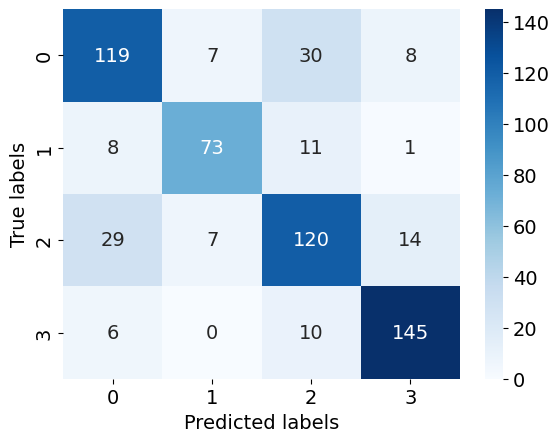

In [70]:
cm = calculate_confusion_matrix(model,x_test_pca,y_test_pca)
print(f'f1 score is: {calculate_f1_score(cm)}')
show_confusion_matrix(model,x_test_pca,y_test_pca)

In [71]:
classification_report_print(x_test_pca,y_test_pca)


19/19 [==============================] - 1s 31ms/step
classification Report 
               precision    recall  f1-score   support

           0       0.73      0.73      0.73       164
           1       0.84      0.78      0.81        93
           2       0.70      0.71      0.70       170
           3       0.86      0.90      0.88       161

    accuracy                           0.78       588
   macro avg       0.78      0.78      0.78       588
weighted avg       0.78      0.78      0.78       588



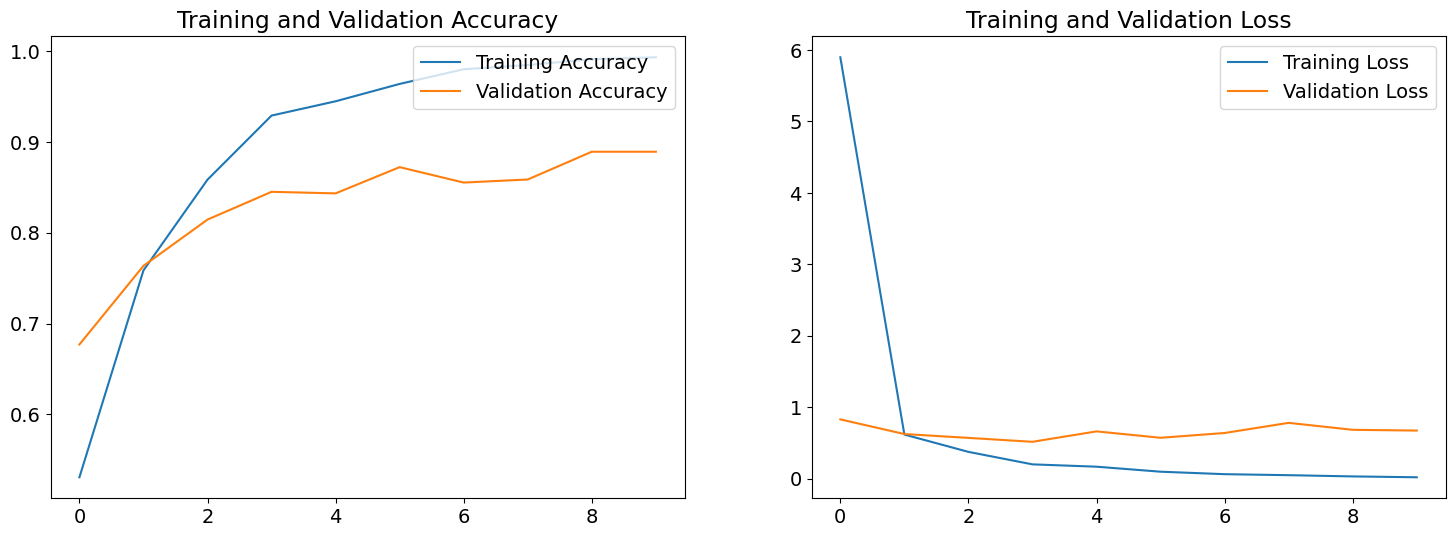

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
